# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели 

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [2]:
!pip install sentencepiece

In [2]:
import torch
import numpy as np
from dataset import TextDataset
import warnings

warnings.filterwarnings('ignore')

if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [2]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [5]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length,)
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью. 

In [3]:
from model import LanguageModel

In [4]:
model = LanguageModel(train_set)

In [6]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs,))
logits = model(indices, lengths)
assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
assert type(generated) == str
assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится. 

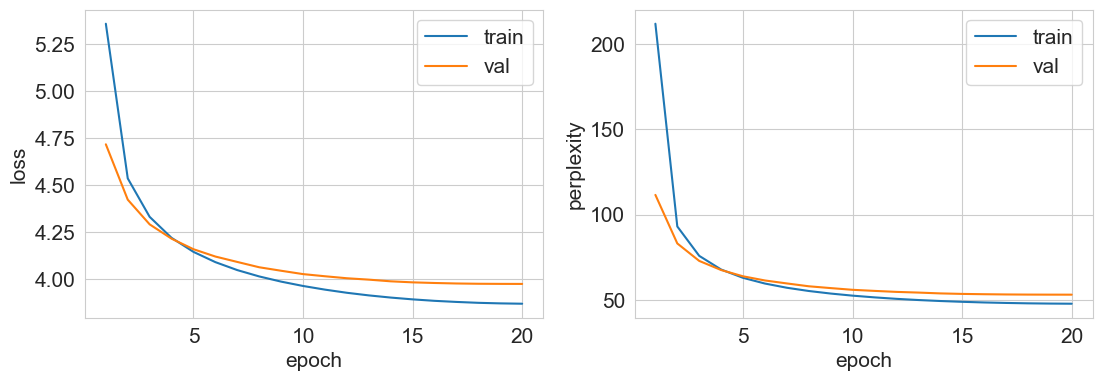

Generation examples:
штирлица веселые сало там ученые, кажется полицейрии.
нет - на буйном местеки наркомановьев обращения на море печке. слышно собирался путин. водитель застухивая.жена- у тебя есть.- почему?- а я вижу, будешь говорят еще пять лет.
видимо. и недорого ко мне надо менее с мужиками.
любие нет наступает себе зайдете от молча.
маленький вылезает жену, мало того, кто из плюс...


In [4]:
from torch.utils.data import DataLoader
from train import train

train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=256, shuffle=False)

model = LanguageModel(train_set).to(device)
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train(model, optimizer, scheduler, train_loader, val_loader, num_epochs)
torch.save(model.state_dict(), f'rnn.pt')

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

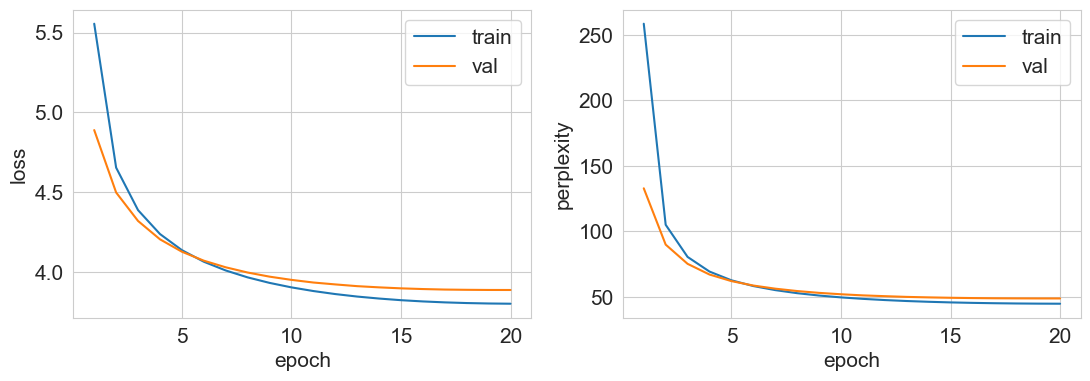

Generation examples:
- вы ест ли китайцы, расстрелять то, что у вас нет?
ровникт ходит в республике, что сплошные полосатые фоны бывают...
сидят один мужик в нью- трамп в хоке нет.- ты меня вытирала...- курицу.- лучше лука бы папочка одна начала входится!
последняя михаил туалетная виагры обрадина ночинаму не говорите, он некото палками и не покупает нос...
путин купил встану поедим на украинскую цену.


In [5]:
model = LanguageModel(train_set, rnn_type=torch.nn.LSTM).to(device)
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train(model, optimizer, scheduler, train_loader, val_loader, num_epochs)
torch.save(model.state_dict(), f'lstm.pt')

Лосс и perplexity у LSTM чуть ниже(то есть лучше). Генерация у LSTM кажется немного лучше, слова более осмысленные.

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы. 

In [6]:
model = LanguageModel(train_set)
model.load_state_dict(torch.load('rnn.pt'))
model = model.to(device)

In [7]:
for temp in np.linspace(0.1, 2, 10):
    print('Temp is', temp)
    for _ in range(3):
        print(model.inference('Девушки - ', temp=temp))
    print()

Temp is 0.1
девушки - это когда ты не можешь найти, что я не могу, а я не знаю, что я не могу.
девушки - это когда ты, когда я нашел в магазин, а потом говорит- а я на тебя не задавал.
девушки - это когда ты не можешь найти, что у меня нет.

Temp is 0.3111111111111111
девушки - это когда ты знаешь, что в россии не было.
девушки - это когда ты не знаешь, что он считает, что они не могут.
девушки - это когда у тебя есть, а я не знаю, что я не знаю, что я не могу.

Temp is 0.5222222222222223
девушки - это когда является на работу, всегда найдется, как вы, а то, что я тебя люблю себя.
девушки - это когда ты поживает меня в кровать, когда она его не получится.
девушки - это когда у тебя вреднести.

Temp is 0.7333333333333333
девушки - сколько весит попасть в точку?
девушки - это когда ты вкуснее, чем в кино.
девушки - это как-то в киеве и появляется в истории.

Temp is 0.9444444444444444
девушки - это точно жирные людьи соседи.
девушки - учитель - репутация выиграли я пользу процессстве, но

In [8]:
for temp in np.linspace(0.1, 2, 10):
    print('Temp is', temp)
    for _ in range(3):
        print(model.inference('Вовочка', temp=temp))
    print()

Temp is 0.1
вовочка, что у меня в жизни, когда я не могу, я не могу, я не могу, а ты не знаешь, что я не могу, я не могу, а ты не знаешь, что я не могу, я не могу, а ты не знаешь, что я не могу, я не могу, я не могу.
вовочка, что у меня в жизни не было, а я не знаю, что он не знает, что он не хочет.
вовочка, что у меня в школе, когда я не могу, я не могу, а ты не знаешь, что я не могу, я не могу, я не могу, а ты не знаешь, что я не могу, я не могу, а я не могу, я не могу.

Temp is 0.3111111111111111
вовочка, что это не на работе, а ты не понравился, но я не могу...
вовочка в постели- мама, а почему ты у меня на работе?- да, я не знаю, что ты не можешь.
вовочка, а ты знаешь, что я не могу свернуть в магазин, а ты не знаешь, что я тебя люблю!- а что вы хотите?- да, но я не знаю, что я тебе не видел!

Temp is 0.5222222222222223
вовочка, нашел на работу, смотрю, что все-таки посещениям, то это уже не уйдешь.
вовочка по улице и спрашивает- я вчера нашел на этой неделе, а то, что я вас не та

In [9]:
for temp in np.linspace(0.1, 2, 10):
    print('Temp is', temp)
    for _ in range(3):
        print(model.inference('Жили-были', temp=temp))
    print()

Temp is 0.1
жили-были, что я не могу, что я не могу, а ты не знаешь, что я не могу, я не могу, а ты не знаешь, что я не могу, а ты не знаешь, что я не могу, я не могу, я не могу, я не могу, я не могу, а ты не знаешь, что ты не можешь, чтобы я не могу, а я не могу, я не могу.
жили-были, что у нас в россии есть, когда в россии - это когда ты не можешь не повторять.
жили-были, что у нас в стране, когда я не могу, что я не могу понять, что я не могу, а ты не знаешь, что я не могу, я не могу, я не могу, а ты не знаешь, что я буду жить в ванной, а в каком-то?- нет, я не знаю, что я не могу.

Temp is 0.3111111111111111
жили-были, а у меня есть двери, а у меня в деревне и не выдерживает, что он не хочет, чтобы научиться.
жили-были, что с тобой не вредно, но не знаешь, что я не могу найти.
жили-были, что на работе не было, а в каком году?

Temp is 0.5222222222222223
жили-были, что ты нашел поставлюсь, а при этом никуда не стыдно!
жили-были, что в россии есть хорошо, когда я в детстве, когда в д

In [10]:
model = LanguageModel(train_set, rnn_type=torch.nn.LSTM)
model.load_state_dict(torch.load('lstm.pt'))
model = model.to(device)

In [11]:
for temp in np.linspace(0.1, 2, 10):
    print('Temp is', temp)
    for _ in range(3):
        print(model.inference('Девушки - ', temp=temp))
    print()

Temp is 0.1
девушки - это когда ты не знаешь, что ты не можешь.
девушки - это когда ты не знаешь, что он не может.
девушки - это когда ты не знаешь, что ты не можешь, то это не доверяю.

Temp is 0.3111111111111111
девушки - это когда-то не срочно, но и не сдавать - не накануться.
девушки - это когда ты не хочешь, то не догадался, что он не любит.
девушки - это когда на работе, то это - не дам.

Temp is 0.5222222222222223
девушки - это когда на улице и компотего!
девушки - это когда муж задумал, то ли мне было находить.
девушки - это когда нужно призовут, то есть, что незаметно, но если бы у него есть.

Temp is 0.7333333333333333
девушки - это когда я сделал ей, что он целый год, поэтому не забираешь...
девушки - это содержание...
девушки - это когда выбирают на себя новой!

Temp is 0.9444444444444444
девушки - болены на двери.
девушки - дядью - пососал.
девушки - российские темы и украины пользованов от трехняльных территории.

Temp is 1.1555555555555557
девушки - самое глуса чиновники

In [12]:
for temp in np.linspace(0.1, 2, 10):
    print('Temp is', temp)
    for _ in range(3):
        print(model.inference('Вовочка', temp=temp))
    print()

Temp is 0.1


вовочка, который в детстве не выдержала, что он не заснул.
вовочка- а ты знаешь, что ты не знаешь, что ты не знаешь, что ты меня любишь?- нет, я не могу.
вовочка приходит домой в дверь, а потом говорит- а ты что, я тебе говорил, что ты не хочешь?

Temp is 0.3111111111111111
вовочка спрашивает- что ты делаешь?- я не знаю, что ты мне не засюда.
вовочка говорит- доктор, я не могу выйти замуж, а потом я нашел.
вовочка приходит домой с девушкой, снимает- а ты знаешь, что ты меня любишь?- нет, я тебе не могу.

Temp is 0.5222222222222223
вовочка приходит домой с работы, и говорит- ты что, ты мне поверять, а ты рассчитался?
вовочка- девушка, вы мне вчера наступили в жизни?- у вас, налогов!
вовочка- не хочешь, я тебя люблю, а я и не могу.

Temp is 0.7333333333333333
вовочка- у меня я твой сыр.- а где?- мой муж.- вы на руках.
вовочка - это когда врача с малойфорам-то, как будто разводится.
вовочка-поджета что-то в россии не зловало.

Temp is 0.9444444444444444
вовочка выдала последних ворчная ст

In [13]:
for temp in np.linspace(0.1, 2, 10):
    print('Temp is', temp)
    for _ in range(3):
        print(model.inference('Жили-были', temp=temp))
    print()

Temp is 0.1
жили-были, что у меня есть, а не в том, что я не знаю, что ты не можешь.
жили-были, что в жизни не было.
жили-были, что у меня в мире, но не понравилось.

Temp is 0.3111111111111111
жили-были на работу.
жили-были, у меня домашний анекдот.
жили-были, не выходишь.

Temp is 0.5222222222222223
жили-были дважды в супермаркете, а вот что, кукруш?
жили-были, неужели выяснилось, что его негр.
жили-были, придешь на работу, и я не знаю, что я - отсутствие!

Temp is 0.7333333333333333
жили-были вспомнить, что это происпать.
жили-были и порепа борожникам с мамой.
жили-былия у кого-то новое танцем, российским космос-спредюренько остановить меня.

Temp is 0.9444444444444444
жили-были, современные завершение размеров с цветовоациейными привычная зарплата устроения дил.
жили-были, играли в своей ногерный вопрос- так, сколько у вас есть?- люблю.- ну я за моем салонки около?!
жили-были делают, что те подмедиться только исчезаваться!

Temp is 1.1555555555555557
жили-были бьтеками.
жили-были р

Вообще температура нужна для следующего: если она больше 1, то мы делаем вероятностное распределение более гладким, из-за чего увеличивается вероятность менее вероятных токенов; если же меньше 1, то таким образом мы увеличиваем вероятность самых вероятных токенов.

Если теперь посмотреть на сгенерированные анекдоты, то можно увидеть, что низкой температурой модель генерирует одно и то же; если же повысить температуру, то получается нечто просто похожее на набор букв. То есть в первом случае постоянно генерируются самые вероятные токены, во втором генерируется всё подряд.

Насчёт префиксов: если префикс часто встречался во время обучение, то модель генерирует что-то напоминающее текст, иначе получается очень странно. Если посмотреть на то, что выше, можно увидеть, что для префикса "жили были" получается что-то несвязное, с девушками и вовочкой лучше. Если поискать вхождение каждого префикса в датасете, то видно, что первого всего 6 вхождений, второго и третьего около 1000.

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

In [ ]:
from torch.utils.data import DataLoader
from train import train

train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe_5000', vocab_size=5000)
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe_5000', vocab_size=5000)

train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=256, shuffle=False)

model = LanguageModel(train_set, rnn_type=torch.nn.LSTM).to(device)
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train(model, optimizer, scheduler, train_loader, val_loader, num_epochs)
torch.save(model.state_dict(), f'lstm_bpe_5000.pt')

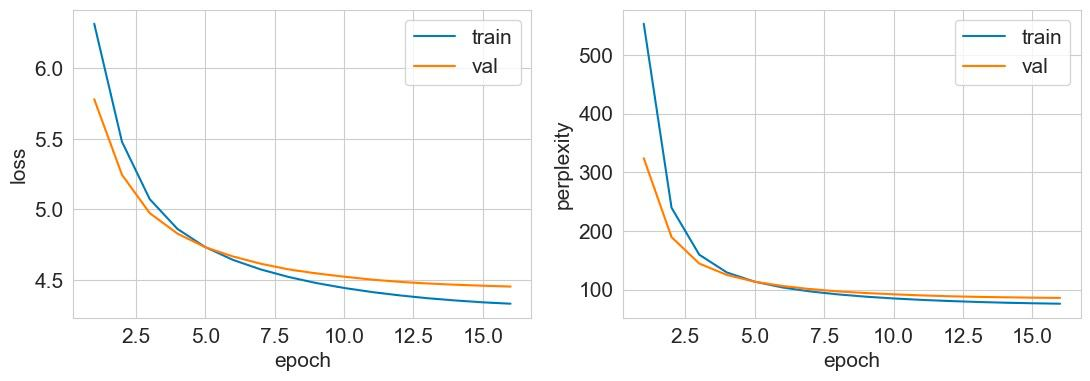

In [11]:
for _ in range(5):
    print(model.inference())

- ты за когочить разбега?- любовница моя форняка, я же штирлиц, малыши про одеждаюсь!
поймал удобная подруги или поздно вечером занариз некоторое время бойся?
хозяин с женщиной, приходи в банолог и ушел на кухню. и он уже не ест, хоть раз к ответаль.
в одной ресторане- вновле, сомневально поливать решаранам для сортиста, блавны!
- в какой отличаются? че дают патриотиздра, зато никто не жить еще надо, как гулять мощляют юрия для тебя мужчин.


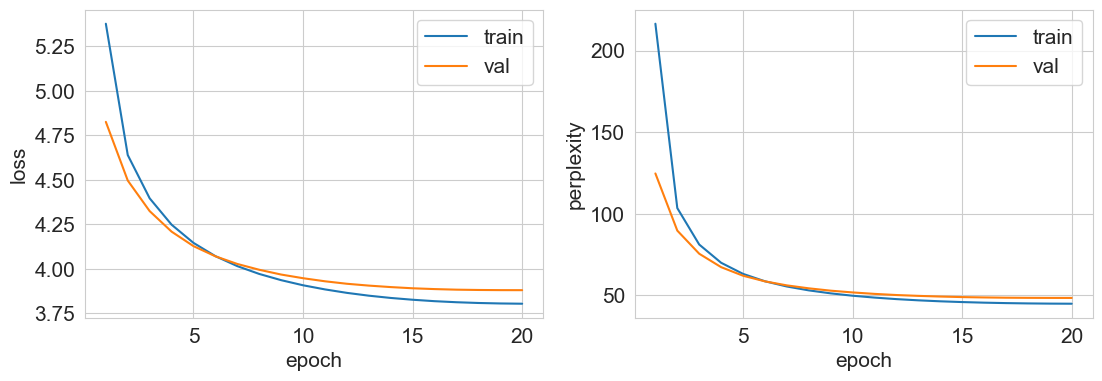

Generation examples:
- брат думара, позволяет номер жирафы, и любили на голове в жизни и два миллиар вашего.
разговаривают - в макторе. в спальне мужик возвращается, включает себя как-нибудь цель смалергал, то внучого агнозапно, не с одной стороны есть еще? вот стоит ⁇ !
не реальноли до меня больше хочешь...
- сдать как, даешь и теща поговорить, чтобы собирать сказать бошь водку.
женская фигля себе в твоем главе место! пришлось! если хотите отвечать рассказан. епсы и нее не передали.


In [6]:
from torch.utils.data import DataLoader
from train import train

train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='unigram', model_type='unigram')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram', model_type='unigram')

train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=256, shuffle=False)

model = LanguageModel(train_set, rnn_type=torch.nn.LSTM).to(device)
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train(model, optimizer, scheduler, train_loader, val_loader, num_epochs)
torch.save(model.state_dict(), f'lstm_unigram.pt')

Что то фигня, что другое. 

Как мне кажется, сравнивать значение лосса и perplixity некорректно, ведь всё зависит именно от метода токенизации и размера vocab. То есть кросс-энтропия будет отличатся, а соответственно perplexity.

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity


def LSA(model: LanguageModel, valid_set: TextDataset):
    texts = []
    for tokens, length in tqdm(valid_set):
        texts.append(valid_set.ids2text(tokens[:length]))
    model.eval()
    for _ in tqdm(range(len(valid_set))):
        texts.append(model.inference())
    X = TfidfVectorizer().fit_transform(texts)
    svd = TruncatedSVD(n_components=100, random_state=0).fit(
        X.T)  #For LSA, a n_components value of 100 is recommended. And transpose X for collapse rows number
    val_vec, gen_vec = svd.components_[:, :len(valid_set)].T, svd.components_[:, len(valid_set):].T
    return val_vec, gen_vec, np.mean(np.max(cosine_similarity(gen_vec, val_vec), axis=1))


In [13]:
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')
model = LanguageModel(valid_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(torch.load('lstm.pt'))
val_bpe, gen_bpe, cs = LSA(model, valid_set)
print(f'Cosine similarity of bpe tokenizer is {cs}')

  0%|          | 0/6037 [00:00<?, ?it/s]

  0%|          | 0/6037 [00:00<?, ?it/s]

Cosine similarity of bpe tokenizer is 0.7499717576752489


In [14]:
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe_5000', vocab_size=5000)
model = LanguageModel(valid_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(torch.load('lstm_bpe_5000.pt'))
val_bpe_5000, gen_bpe_5000, cs = LSA(model, valid_set)
print(f'Cosine similarity of bpe tokenizer and vocab size = 5000 is {cs}')

  0%|          | 0/6037 [00:00<?, ?it/s]

  0%|          | 0/6037 [00:00<?, ?it/s]

Cosine similarity of bpe tokenizer and vocab size = 5000 is 0.7518972895791517


In [15]:
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram', model_type='unigram')
model = LanguageModel(valid_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(torch.load('lstm_unigram.pt'))
val_unigram, gen_unigram, cs = LSA(model, valid_set)
print(f'Cosine similarity of unigram tokenizer is {cs}')

  0%|          | 0/6037 [00:00<?, ?it/s]

  0%|          | 0/6037 [00:00<?, ?it/s]

Cosine similarity of unigram tokenizer is 0.7524000449939432


In [16]:
np.save('val_bpe.npy', val_bpe)
np.save('gen_bpe.npy', gen_bpe)
np.save('val_bpe_5000.npy', val_bpe_5000)
np.save('gen_bpe_5000.npy', gen_bpe_5000)
np.save('val_unigram.npy', val_unigram)
np.save('gen_unigram.npy', gen_unigram)

Минусы: слишком много вычислений(ну типа сначала сделать генерацию, потом свд посчитать)
Плюсы: опять же из-за свд мы уменьшаем размерность, а не просто усреднение.

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов. 

In [17]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

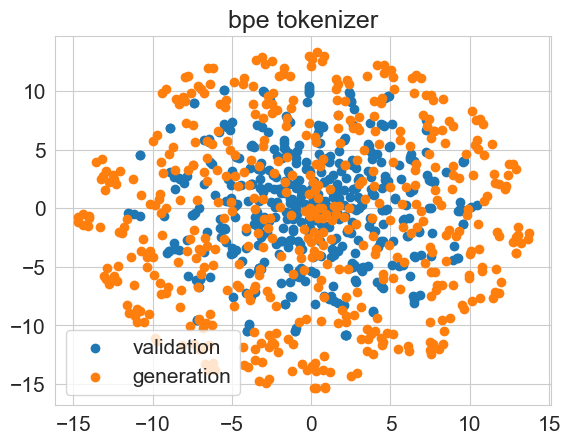

In [18]:
val_bpe = np.load('val_bpe.npy')
gen_bpe = np.load('gen_bpe.npy')

val_bpe = val_bpe[np.random.randint(val_bpe.shape[0], size=500)]
gen_bpe = gen_bpe[np.random.randint(gen_bpe.shape[0], size=500)]


val_bpe = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=50).fit_transform(val_bpe)
gen_bpe = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=50).fit_transform(val_bpe)


plt.scatter(val_bpe[:, 0], val_bpe[:, 1], label='validation')
plt.scatter(gen_bpe[:, 0], gen_bpe[:, 1], label='generation')

plt.legend()
plt.title('bpe tokenizer')
plt.show()

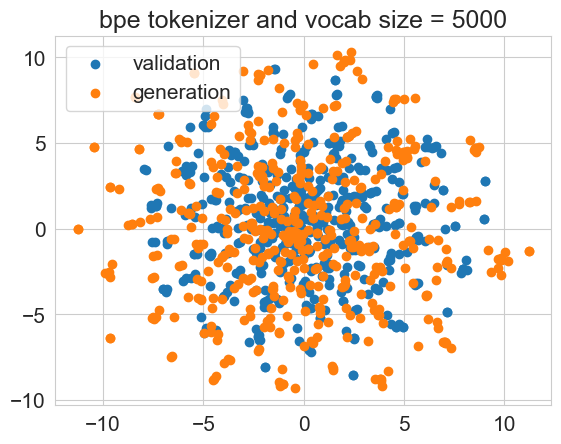

In [19]:
val_bpe_5000 = np.load('val_bpe_5000.npy')
gen_bpe_5000 = np.load('gen_bpe_5000.npy')

val_bpe_5000 = val_bpe_5000[np.random.randint(val_bpe_5000.shape[0], size=500)]
gen_bpe_5000 = gen_bpe_5000[np.random.randint(gen_bpe_5000.shape[0], size=500)]


val_bpe_5000 = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=50).fit_transform(val_bpe_5000)
gen_bpe_5000 = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=50).fit_transform(gen_bpe_5000)


plt.scatter(val_bpe_5000[:, 0], val_bpe_5000[:, 1], label='validation')
plt.scatter(gen_bpe_5000[:, 0], gen_bpe_5000[:, 1], label='generation')

plt.legend()
plt.title('bpe tokenizer and vocab size = 5000')
plt.show()

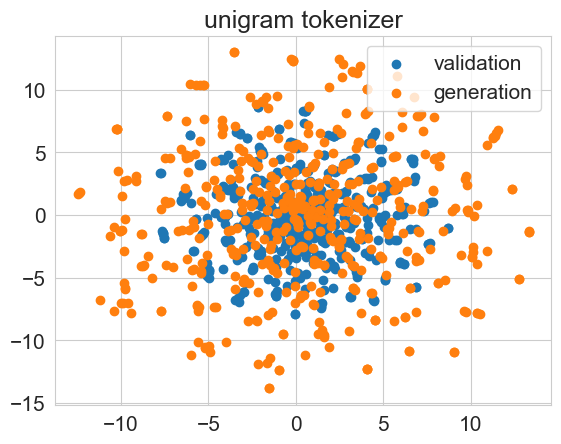

In [20]:
val_unigram = np.load('val_unigram.npy')
gen_unigram = np.load('gen_unigram.npy')

val_unigram = val_unigram[np.random.randint(val_unigram.shape[0], size=500)]
gen_unigram = gen_unigram[np.random.randint(gen_unigram.shape[0], size=500)]


val_unigram = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=50).fit_transform(val_unigram)
gen_unigram = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=50).fit_transform(gen_unigram)


plt.scatter(val_unigram[:, 0], val_unigram[:, 1], label='validation')
plt.scatter(gen_unigram[:, 0], gen_unigram[:, 1], label='generation')

plt.legend()
plt.title('unigram tokenizer')
plt.show()

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [21]:
# !pip install transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
model_checkpoint = 'ai-forever/rugpt3small_based_on_gpt2'

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
gpt = AutoModelForCausalLM.from_pretrained(model_checkpoint).to(device)

In [23]:
def perplexity(model:LanguageModel, big_model=gpt):
    encodings = tokenizer("\n\n".join([model.inference() for i in tqdm(range(1024))]), return_tensors="pt")
    max_length = big_model.config.n_positions
    stride = 512
    seq_len = encodings.input_ids.size(1)

    nlls = []
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = big_model(input_ids, labels=target_ids)

            # loss is calculated using CrossEntropyLoss which averages over valid labels
            # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
            # to the left by 1.
            neg_log_likelihood = outputs.loss

        nlls.append(neg_log_likelihood)

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break

    return torch.exp(torch.stack(nlls).mean()).item()

In [25]:
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')
model = LanguageModel(valid_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(torch.load('lstm.pt'))
# print(f'Perplexity of model with bpe tokenizer is {perplexity(model)}')
print('Perplexity of model with bpe tokenizer is 5.315722942352295')

Perplexity of model with bpe tokenizer is 5.315722942352295


In [27]:
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe_5000', vocab_size=5000)
model = LanguageModel(valid_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(torch.load('lstm_bpe_5000.pt'))
# print(f'Perplexity of model with bpe tokenizer and vocab size=5000 is {perplexity(model)}')
print('Perplexity of model with bpe tokenizer and vocab size=5000 is 5.204381465911865')

Perplexity of model with bpe tokenizer and vocab size=5000 is 5.204381465911865


In [29]:
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram', model_type='unigram')
model = LanguageModel(valid_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(torch.load('lstm_unigram.pt'))
# print(f'Perplexity of model with unigram tokenizer is {perplexity(model)}')
print('Perplexity of model with unigram tokenizer is 5.460483074188232')

Perplexity of model with unigram tokenizer is 5.460483074188232


## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.

'Выборы - геморой.'